# Analyzing  Vektis open data
This jupyter Notebook uses some of the open data from Vektis (https://www.vektis.nl/intelligence/open-data). It analyses the cost by municipality and is fully parameterized.

It can be used both online and offline. When online the program will download the data from the website. To use it offline, make sure to download the required files to the 'source' folder of the current folder. Some (sub)results can be exported to CSV. These files will be stored in the 'data'folder of the curent folder.

Some of these results can be further displayed on a map of The Netherlands using another jupyter Notebook which is also found in this folder: 2.Vektis (Github Netherlands Choropleth map bokeh).ipynb.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
%matplotlib inline 

Set the parameters.

In [2]:
# When True, the code will try to connect to the data-files on the Vektis website through http.
# When False, make sure to download the files to the 'source' folder
online = False

# When True, the code will save a few of the acquired DataFrames to csv for further analysis in e.g. Excel
export = True

# What should be analyzed?
analyse_jaar     = '2012'
analyse_gemeente = 'GOUDA'
analyse_kosten   = 'KOSTEN_FARMACIE'
analyse_per      = 'AANTAL_VERZEKERDEJAREN'

#KOSTEN: KOSTEN_FARMACIE ,KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG, KOSTEN_HUISARTS_CONSULT, KOSTEN_HULPMIDDELEN, KOSTEN_MONDZORG, KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE, KOSTEN_KRAAMZORG, KOSTEN_VERLOSKUNDIGE_ZORG
#PER: AANTAL_BSN, AANTAL_VERZEKERDEJAREN

Let's do the actual import of the information about municipalities from Vektis. As this file is quite large, it is processed in chunks. From each each chunk only the relevant information is saved for later analyses.

In [3]:
def importVektisDataMunicipalities (yearAnalysis, costAnalysis, perAnalysis, online, chunksize):
    """import the correct CSV file for municipalities and return a pandas DataFrame. Just keeps information about 
    the name of the municipality, gender, age-categories, requested costs and number of insured years (as an alternative measure 
    for the number of people.
    
    Parameters:
        online (boolean): determines whether the file should be read from the website of Vektis or from the data-subfolder
        year (str): determines which year needs to be imported
        costAnalysis (str): determines which costs column will be imported (and later analysed)
        perAnalysis (str): the selected column will be normalized by dividing it by the indicated column (e.g. per 'AANTAL_VERZEKERDEJAREN')
        chunksize (int): chunksize for processing the CSV file

    Returns:
        dataframe:the pandas DataFrame containing the requested information
    """
    if online:
        url = 'https://www.vektis.nl/uploads/Docs%20per%20pagina/Open%20Data%20Bestanden/Oud/OpenData%20' + yearAnalysis + '%20gem-5jcat.csv'
    else:
        url = 'source/OpenData ' + yearAnalysis + ' gem-5jcat.csv'

    #create empty DataFrame
    df_ret = pd.DataFrame()

    #create reader for chunk-wise reading of large .csv
    reader = pd.read_csv(url, sep=';', header=0, chunksize=chunksize, skiprows=[1])

    #only keep relevant information
    for chunk in reader:
        chunk = chunk[['GEMEENTENAAM', 'GESLACHT', 'LEEFTIJDSKLASSE', costAnalysis, perAnalysis]]
        df_ret = df_ret.append(chunk)

    return df_ret

df = importVektisDataMunicipalities(analyse_jaar, analyse_kosten, analyse_per, online, 10000)

df.head()

,GEMEENTENAAM,GESLACHT,LEEFTIJDSKLASSE,KOSTEN_FARMACIE,AANTAL_VERZEKERDEJAREN
0,AA EN HUNZE,M,0 t/m 4 jaar,37469.66,476.33
1,AALBURG,M,0 t/m 4 jaar,42681.21,409.10
2,AALSMEER,M,0 t/m 4 jaar,69600.14,893.20
3,AALTEN,M,0 t/m 4 jaar,53977.59,676.43
4,ACHTKARSPELEN,M,0 t/m 4 jaar,55378.07,792.24


df_municipalities contains detailed information about all municipalities (including gender and age categories).

In [4]:
def processMunicipalities (df, costAnalysis, perAnalysis):
    """Processes the dataframe. Calculates the indicated costs per person, and just keeps the required columns.
    
    Parameters:
        df (dataframe): the dataframe containing the 'raw' data (from importVektisDataMunicipality)
        costAnalysis (str): determines which costs column will be analysed
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')

    Returns:
        dataframe:the pandas DataFrame containing the requested information
    """
    analysisColumnName = costAnalysis + ' per ' + perAnalysis
    
    df[analysisColumnName] = df[costAnalysis] / df[perAnalysis]
    df_ret = df[['GEMEENTENAAM', 'GESLACHT', 'LEEFTIJDSKLASSE', analysisColumnName, perAnalysis]]
    df.drop(analysisColumnName, axis=1)
    
    return df_ret

df_municipalities = processMunicipalities(df, analyse_kosten, analyse_per)

df_municipalities.head()

,GEMEENTENAAM,GESLACHT,LEEFTIJDSKLASSE,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN,AANTAL_VERZEKERDEJAREN
0,AA EN HUNZE,M,0 t/m 4 jaar,78.663238,476.33
1,AALBURG,M,0 t/m 4 jaar,104.329528,409.10
2,AALSMEER,M,0 t/m 4 jaar,77.922235,893.20
3,AALTEN,M,0 t/m 4 jaar,79.797747,676.43
4,ACHTKARSPELEN,M,0 t/m 4 jaar,69.900624,792.24


df_country contains the analysed value per municipality for the entire country.

In [5]:
def processCountry_old(df, costAnalysis, perAnalysis):
    """Processes the dataframe. Calculates the information for each municipality. Both the data of the entire municipality as well as the data per gender category.
    
    Parameters:
        df (dataframe): the dataframe containing the 'raw' data (from importVektisDataMunicipality)
        costAnalysis (str): determines which costs column will be analysed
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')

    Returns:
        dataframe:the pandas DataFrame containing the requested information
    """
    analysisColumnName = costAnalysis + ' per ' + perAnalysis
 
    # Calculate the overall mean of each municipality
    df_ret = df.pivot_table(index=['GEMEENTENAAM'], values=[costAnalysis, perAnalysis], aggfunc=sum)
    df_ret[analysisColumnName] = df_ret[costAnalysis] / df_ret[perAnalysis]
    df_ret = df_ret.drop([costAnalysis,perAnalysis], axis=1)
    
    # Calculate the mean per gender for each municipality
    df_ret2 = df.pivot_table(index=['GEMEENTENAAM', 'GESLACHT'], values=[costAnalysis, perAnalysis], aggfunc=sum)
    df_ret2 = df_ret2.unstack('GESLACHT')
    df_ret2.columns = df_ret2.columns.map(' '.join)
    df_ret2[analysisColumnName + ' M'] = df_ret2[costAnalysis + ' M'] / df_ret2[perAnalysis + ' M']
    df_ret2[analysisColumnName + ' V'] = df_ret2[costAnalysis + ' V'] / df_ret2[perAnalysis + ' V']
    df_ret2 = df_ret2.drop([costAnalysis + ' M', costAnalysis + ' V'], axis=1)

    df_ret = pd.concat([df_ret,df_ret2], axis=1)
    
    return df_ret

df_country_old = processCountry_old(df, analyse_kosten, analyse_per)

df_country_old.head()
#df_country_old.loc[analyse_gemeente]

,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN,AANTAL_VERZEKERDEJAREN M,AANTAL_VERZEKERDEJAREN V,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN M,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN V
GEMEENTENAAM,,,,,
AA EN HUNZE,263.022335,12643.98,12894.41,250.445965,275.354453
AALBURG,261.316860,6372.08,6230.03,225.767424,297.676854
AALSMEER,255.851430,14977.59,15259.15,245.287506,266.220431
AALTEN,276.775827,13281.79,13390.81,237.489528,315.742281
ACHTKARSPELEN,248.229568,14150.42,13796.33,213.649497,283.697156


In [6]:
def processCountry(df, costAnalysis, perAnalysis):
    """Processes the dataframe. Calculates the information for each municipality. Both the data of the entire municipality as well as the data per gender category.
    
    Parameters:
        df (dataframe): the dataframe containing the 'raw' data (from importVektisDataMunicipality)
        costAnalysis (str): determines which costs column will be analysed
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')

    Returns:
        dataframe:the pandas DataFrame containing the requested information
    """
    analysisColumnName = costAnalysis + ' per ' + perAnalysis
 
    # Calculate the overall mean of each municipality
    df_ret = df.pivot_table(index=['GEMEENTENAAM'], values=[costAnalysis, perAnalysis], aggfunc=sum)
    df_ret[analysisColumnName] = df_ret[costAnalysis] / df_ret[perAnalysis]
    df_ret = df_ret.drop([costAnalysis,perAnalysis], axis=1)
    
    # Calculate the mean per gender for each municipality
    df_ret2 = df.pivot_table(index=['GEMEENTENAAM', 'GESLACHT'], values=[costAnalysis, perAnalysis], aggfunc=sum)
    df_ret2[analysisColumnName] = 0
    df_ret2 = df_ret2.unstack('GESLACHT')
    df_ret2.loc[:,(analysisColumnName,'M')] = ( df_ret2[costAnalysis]['M'] / df_ret2[perAnalysis]['M'] )
    df_ret2.loc[:,(analysisColumnName,'V')] = ( df_ret2[costAnalysis]['V'] / df_ret2[perAnalysis]['V'] )
    df_ret2 = df_ret2.drop([costAnalysis], axis=1)

    return df_ret, df_ret2

df_country, df_countryGender = processCountry(df, analyse_kosten, analyse_per)

df_country.head()
df_countryGender.head()
#df_country.loc[analyse_gemeente]
#df_countryGender['AANTAL_VERZEKERDEJAREN'].head()

AANTAL_VERZEKERDEJAREN            \
GESLACHT                           M         V   
GEMEENTENAAM                                     
AA EN HUNZE                 12643.98  12894.41   
AALBURG                      6372.08   6230.03   
AALSMEER                    14977.59  15259.15   
AALTEN                      13281.79  13390.81   
ACHTKARSPELEN               14150.42  13796.33   

              KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN              
GESLACHT                                               M           V  
GEMEENTENAAM                                                          
AA EN HUNZE                                   250.445965  275.354453  
AALBURG                                       225.767424  297.676854  
AALSMEER                                      245.287506  266.220431  
AALTEN                                        237.489528  315.742281  
ACHTKARSPELEN                                 213.649497  283.697156

df_boxplotData_cost and df_boxplotData_per contain information required for a box plot of the average values within the country (both genders).

In [7]:
def prepareBoxplotData_old(df, costAnalysis, perAnalysis):
    """Reshapes the dataframe data to make Boxplots by gender and age-category (later).
    
    Parameters:
        df (dataframe): the dataframe containing the single column dataframe
        costAnalysis (str): determines which costs column will be analysed. If empty ('') the data from the 'per' column will be analysed
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')

    Returns:
        dataframe:the pandas DataFrame containing the requested information
    """
    if costAnalysis != '':
        analysisColumnName = costAnalysis + ' per ' + perAnalysis
        df[analysisColumnName] = df[costAnalysis] / df[perAnalysis]
    else:
        analysisColumnName = perAnalysis

    df_ret = df[['GESLACHT','LEEFTIJDSKLASSE', 'GEMEENTENAAM', analysisColumnName]]
    df_ret = df_ret.pivot_table(index=['GEMEENTENAAM'],columns=['GESLACHT','LEEFTIJDSKLASSE'], values=[analysisColumnName], aggfunc=sum, fill_value=0)

    if costAnalysis != '':
        df.drop(analysisColumnName, axis=1)

    df_ret.columns = df_ret.columns.droplevel(0)
    df_ret.reset_index(inplace=True)
    
    return df_ret

df_boxplotData_cost = prepareBoxplotData_old(df, analyse_kosten, analyse_per)
df_boxplotData_per  = prepareBoxplotData_old(df, '', analyse_per)

df_boxplotData_per.head()

GESLACHT          GEMEENTENAAM              M                                \
LEEFTIJDSKLASSE                 0 t/m  4 jaar  5 t/m  9 jaar 10 t/m 14 jaar   
0                  AA EN HUNZE         476.33         725.00         825.50   
1                      AALBURG         409.10         429.32         497.76   
2                     AALSMEER         893.20        1088.29        1032.17   
3                       AALTEN         676.43         845.46         883.02   
4                ACHTKARSPELEN         792.24         985.11         971.12   

GESLACHT                                                                     \
LEEFTIJDSKLASSE 15 t/m 19 jaar 20 t/m 24 jaar 25 t/m 29 jaar 30 t/m 34 jaar   
0                       793.44         560.72         416.85         423.47   
1                       442.78         391.89         357.05         365.31   
2                       833.46         779.79         633.50         752.25   
3                       811.69         676.33         635.46         652.42   
4                       888.63         822.67         785.78         800.28   

GESLACHT                                       ...              V  \
LEEFTIJDSKLASSE 35 t/m 39 jaar 40 t/m 44 jaar  ... 45 t/m 49 jaar   
0                       612.35         927.39  ...        1078.27   
1                       337.46         506.64  ...         515.84   
2                      1029.53        1357.72  ...        1296.38   
3                       710.47        1057.67  ...        1027.41   
4                       830.91        1103.70  ...        1000.38   

GESLACHT                                                                     \
LEEFTIJDSKLASSE 50 t/m 54 jaar 55 t/m 59 jaar 60 t/m 64 jaar 65 t/m 69 jaar   
0                      1106.95        1032.33        1107.40         916.71   
1                       393.13         360.89         385.03         308.78   
2                      1064.35         825.84         834.39         840.24   
3                      1037.08         916.35         858.38         863.77   
4                       997.16         921.63         902.17         779.89   

GESLACHT                                                                     \
LEEFTIJDSKLASSE 70 t/m 74 jaar 75 t/m 79 jaar 80 t/m 84 jaar 85 t/m 89 jaar   
0                       686.52         562.05         422.11         257.15   
1                       232.94         177.71         155.03         102.99   
2                       657.10         463.04         394.81         244.21   
3                       635.60         530.64         441.09         288.85   
4                       608.32         485.04         341.55         251.93   

GESLACHT                 
LEEFTIJDSKLASSE     90+  
0                158.92  
1                 53.79  
2                173.45  
3                151.41  
4                128.24  

[5 rows x 39 columns]

In [8]:
def prepareBoxplotData(df, costAnalysis, perAnalysis):
    """Reshapes the dataframe data to make Boxplots by gender and age-category (later).
    
    Parameters:
        df (dataframe): the dataframe containing the single column dataframe
        costAnalysis (str): determines which costs column will be analysed. If empty ('') the data from the 'per' column will be analysed
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')

    Returns:
        dataframe:the pandas DataFrame containing the requested information
    """
    if costAnalysis != '':
        analysisColumnName = costAnalysis + ' per ' + perAnalysis
        df[analysisColumnName] = df[costAnalysis] / df[perAnalysis]
    else:
        analysisColumnName = perAnalysis

    df_ret = df[['GESLACHT','LEEFTIJDSKLASSE', 'GEMEENTENAAM', analysisColumnName,perAnalysis]]
    df_ret = df_ret.pivot_table(index=['GEMEENTENAAM'],columns=['GESLACHT','LEEFTIJDSKLASSE'], values=[analysisColumnName,perAnalysis], aggfunc=sum, fill_value=0)

    df_ret.reset_index(inplace=True)
    
    return df_ret

df_boxplotData = prepareBoxplotData(df, analyse_kosten, analyse_per)

df_boxplotData.head()
#df_boxplotData[analyse_per].head()
#df_boxplotData[analyse_per]['M'].head()

GEMEENTENAAM AANTAL_VERZEKERDEJAREN                 \
GESLACHT                                            M                  
LEEFTIJDSKLASSE                         0 t/m  4 jaar  5 t/m  9 jaar   
0                  AA EN HUNZE                 476.33         725.00   
1                      AALBURG                 409.10         429.32   
2                     AALSMEER                 893.20        1088.29   
3                       AALTEN                 676.43         845.46   
4                ACHTKARSPELEN                 792.24         985.11   

                                                                             \
GESLACHT                                                                      
LEEFTIJDSKLASSE 10 t/m 14 jaar 15 t/m 19 jaar 20 t/m 24 jaar 25 t/m 29 jaar   
0                       825.50         793.44         560.72         416.85   
1                       497.76         442.78         391.89         357.05   
2                      1032.17         833.46         779.79         633.50   
3                       883.02         811.69         676.33         635.46   
4                       971.12         888.63         822.67         785.78   

                                                              ...  \
GESLACHT                                                      ...   
LEEFTIJDSKLASSE 30 t/m 34 jaar 35 t/m 39 jaar 40 t/m 44 jaar  ...   
0                       423.47         612.35         927.39  ...   
1                       365.31         337.46         506.64  ...   
2                       752.25        1029.53        1357.72  ...   
3                       652.42         710.47        1057.67  ...   
4                       800.28         830.91        1103.70  ...   

                KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN                 \
GESLACHT                                                 V                  
LEEFTIJDSKLASSE                             45 t/m 49 jaar 50 t/m 54 jaar   
0                                               182.001169     250.304485   
1                                               232.203668     329.744487   
2                                               214.205387     200.861850   
3                                               255.986130     254.869644   
4                                               312.661998     284.334831   

                                                                             \
GESLACHT                                                                      
LEEFTIJDSKLASSE 55 t/m 59 jaar 60 t/m 64 jaar 65 t/m 69 jaar 70 t/m 74 jaar   
0                   293.435045     312.411604     411.876100     546.407548   
1                   318.289174     429.201491     580.177635     752.244398   
2                   325.059479     526.385096     443.720068     555.700867   
3                   460.314028     401.465586     686.209929     609.648993   
4                   383.698350     395.247692     528.861339     618.003386   

                                                                           
GESLACHT                                                                   
LEEFTIJDSKLASSE 75 t/m 79 jaar 80 t/m 84 jaar 85 t/m 89 jaar          90+  
0                   640.487715     791.189335     919.081626   957.973320  
1                   859.989140     933.202735    1267.438878   979.326827  
2                   708.722724     889.692637    1043.771426  1370.039320  
3                   682.851557     807.064046     875.424373   926.363120  
4                   701.374175     812.318196    1083.954591  1097.531425  

[5 rows x 77 columns]

The information about the different municipalities can be easily used to assess which municipalities could be considered outliers.

In [9]:
def calculateOutliers(df, costAnalysis, perAnalysis):
    """Calculates the outliers from the dataframe.
    
    Parameters:
        df (dataframe): the dataframe containing the data from all municipalities in the country
        costAnalysis (str): determines which costs column will be analysed. If empty ('') the data from the 'per' column will be analysed
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')

    Returns:
        dataframe:the pandas DataFrame containing the requested information
    """   
    if costAnalysis != '':
        analysisColumnName = costAnalysis + ' per ' + perAnalysis
    else:
        analysisColumnName = perAnalysis
        
    analyse_kolom = analyse_kosten + ' per ' + analyse_per

    p2_5, p97_5 = np.percentile(df[analysisColumnName],[2.5,97.5])

    df_temp = df_country[analysisColumnName]
    
    return df_temp[ df_temp < p2_5  ].append(df_temp[ df_temp > p97_5 ]).sort_values().reset_index()

df_country_outliers = calculateOutliers(df_country, analyse_kosten, analyse_per)

df_country_outliers

,GEMEENTENAAM,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
0,KOGGENLAND,199.453111
1,URK,202.195043
2,STAPHORST,204.772696
3,DRECHTERLAND,208.495101
4,FERWERDERADIEL,211.013255
5,BEEMSTER,213.349108
6,MONTFOORT,214.230032
7,LANGEDIJK,215.144668
8,MIDDEN-DELFLAND,217.359250
9,UITGEEST,217.701550


Let's do some graphical inspection of the averages around the country.

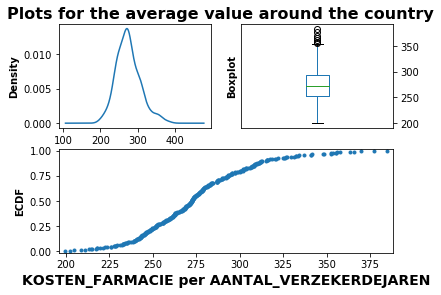

In [10]:
def ecdf(data):
    """Compute ECDF (Empirical cumulative distribution function) for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

def plotSpreads(df, costAnalysis, perAnalysis):
    """Plots three different plots for the provide (single column) Dataframe: (1) the PDF (Probability Density Function, (2) the boxplot,
    and (3) the ECDF (Empirical cumulative distribution function)

    Parameters:
        df (dataframe): the dataframe containing the single column dataframe
        costAnalysis (str): determines which costs column will be analysed
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')
    """ 
    analysisColumnName = costAnalysis + ' per ' + perAnalysis
    
    fig = plt.figure()
    _ = fig.suptitle('Plots for the average value around the country', fontweight='bold', fontsize=16)
    gs = GridSpec(2, 2, figure = fig)

    ax1 = fig.add_subplot(gs[0, 0])

    # Probability Density Functions (PDF)
    _ = df[analysisColumnName].plot.kde(ax=ax1)
    _ = ax1.set_ylabel('Density', fontweight='bold')
    
    ax2 = fig.add_subplot(gs[0, 1])
    # Box plot
    _ = df[analysisColumnName].plot(ax=ax2, kind='box', showfliers=True)
    #_ = ax2.yaxis.set_label_position("right")
    _ = ax2.set_ylabel('Boxplot', fontweight='bold')
    _ = ax2.yaxis.tick_right()
    _ = ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[1, :])
    # ECDF
    x,y = ecdf(df[analysisColumnName])
    _ = ax3.plot(x, y, marker='.', linestyle='none')
    _ = ax3.set_ylabel('ECDF', fontweight='bold')
    _ = ax3.margins(0.02) # Keeps data off plot edges
    
    _ = plt.subplots_adjust(top=0.92)
    _ = plt.xlabel(analysisColumnName, fontweight='bold', fontsize=14)
    
    plt.show()
    
plotSpreads(df_country, analyse_kosten, analyse_per)

Now that all information is processed, it's possible to export the dataframes to csv for further review or analyses.

In [11]:
analyse_kolom = analyse_kosten + ' per ' + analyse_per

if export:
    df_municipalities.to_csv(        'data/df_vektis_demography_' + analyse_jaar + '_' + analyse_gemeente + '.csv', decimal=',', index=True)
    df_country[analyse_kolom].to_csv('data/df_vektis_'            + analyse_jaar +                          '.csv', decimal=',', index=True, header=True)
    df_country_outliers.to_csv(      'data/outliers_'             + analyse_jaar +                          '.csv', decimal=',', index=False)

Let's make a nice plot of the information. The plot will show a population-like pyramid for the selected municipality as well as a boxplot for the country.

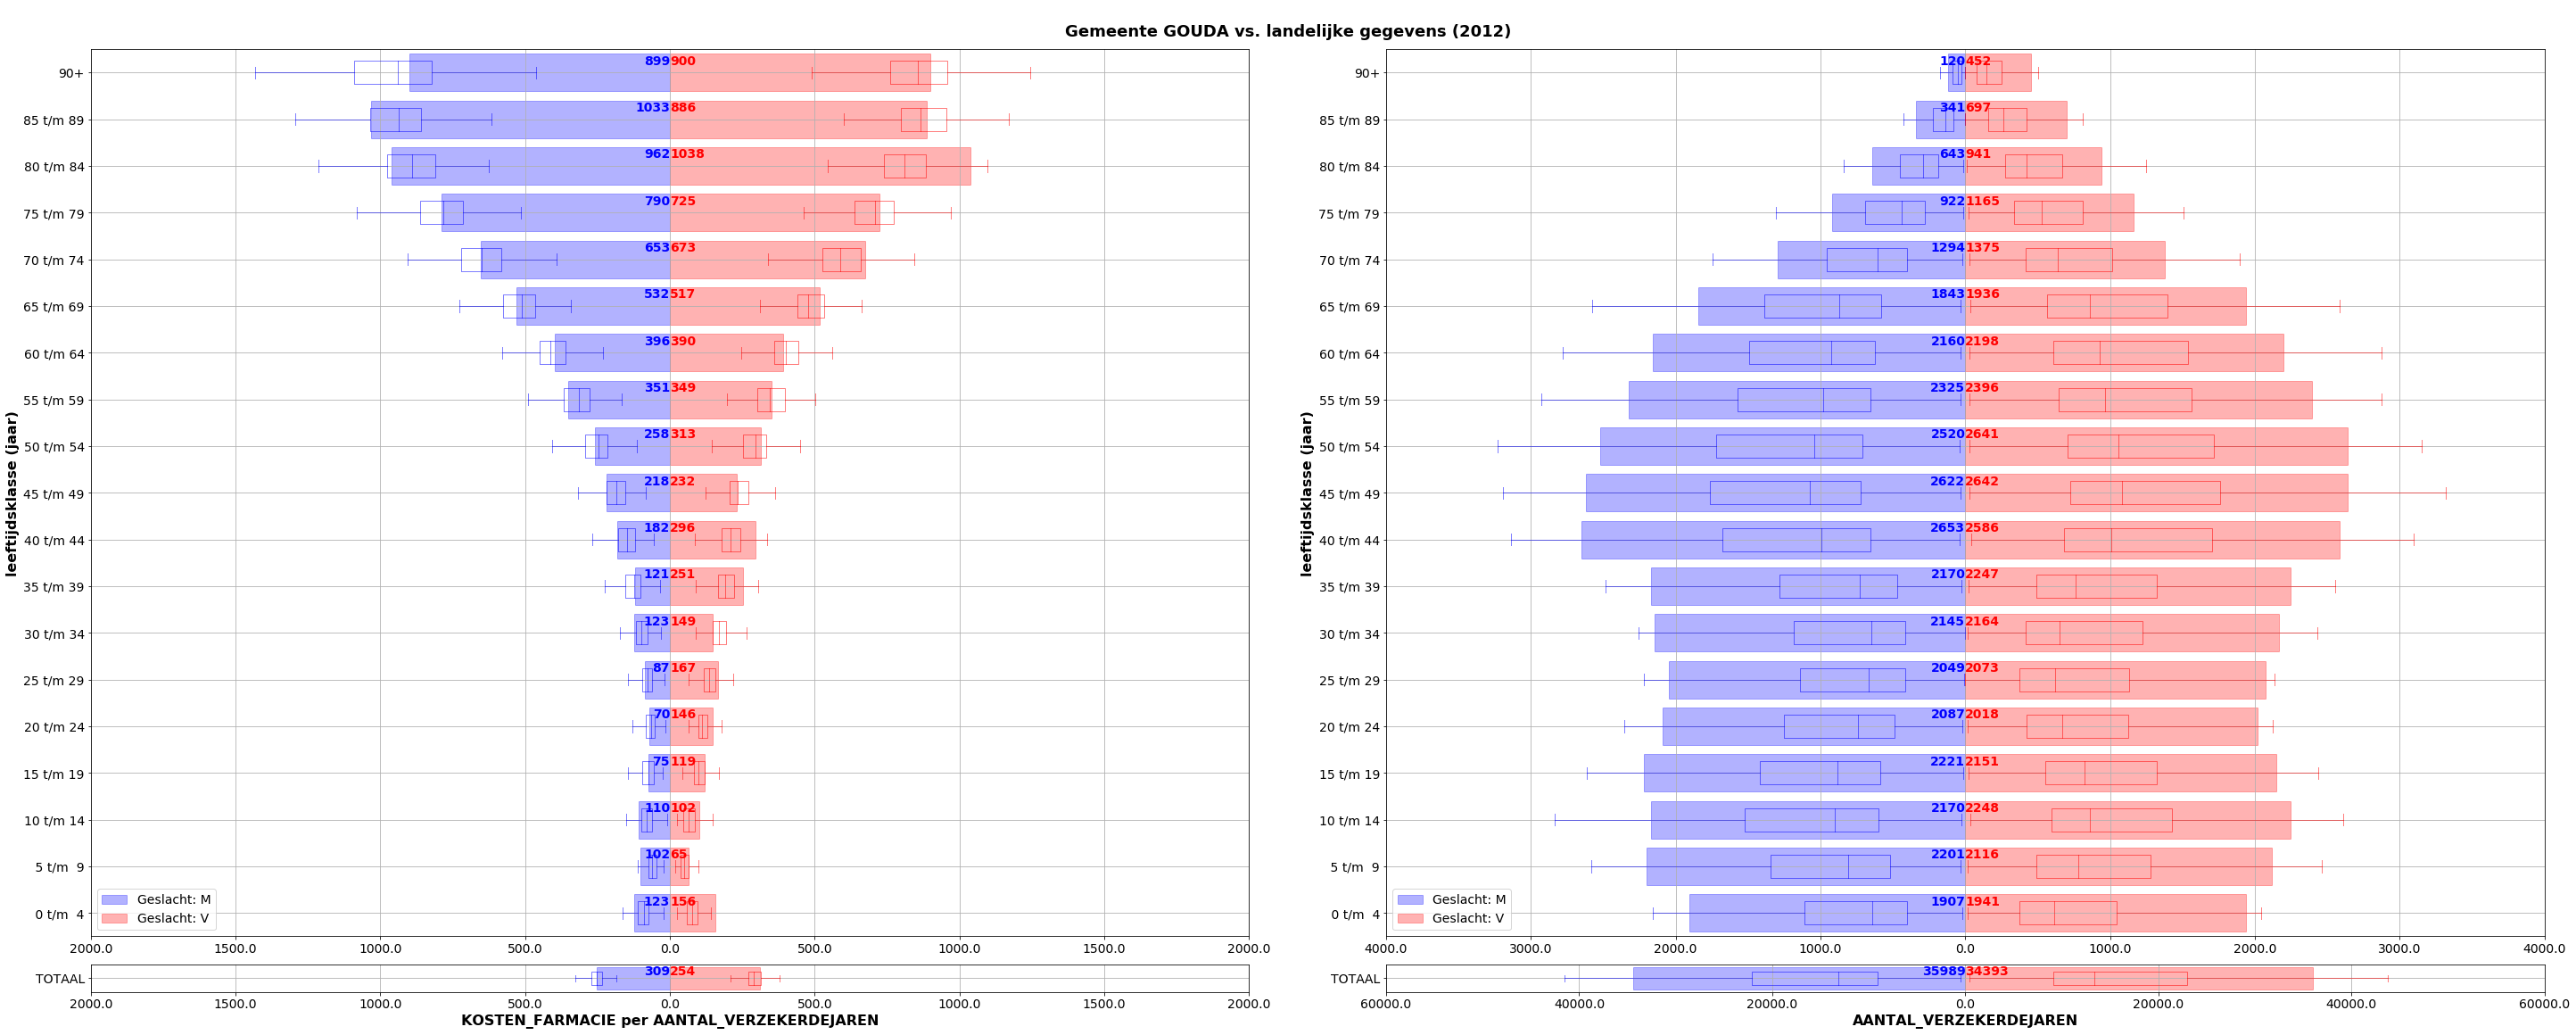

In [12]:
fontSize = 14

def draw_boxplot(ax, data, edge_color, fill_color, alpha=1, showfliers=True):
    '''Shows boxplots of data along the ax axis'''
    #flierprops = dict(marker='o', markerfacecolor='r', markersize=12,linestyle='none', markeredgecolor='g')

    if isinstance(data, pd.DataFrame):
        rangeSize = data.shape[1]
    else:
        rangeSize = 1
    
    #bp_dict = data.boxplot(vert=False, return_type='dict', showfliers=showfliers) #pandas version 
    bp_dict = ax.boxplot(data.values, vert=False, positions=range(1, 1+ rangeSize), widths=0.5, showfliers=showfliers)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp_dict[element], color=edge_color, alpha=alpha)
    plt.setp(bp_dict['fliers'], markeredgecolor=edge_color, markerfacecolor=fill_color)

def fillAgeCategories(df, geslacht, analysisColumn, labs):
    """"Transfer the information to a gender specific dataframe. We make sure all age categories are used by initializing a
    dataframe with all labels and '0' value.
    """
    df_ret = df[df['GESLACHT'] == geslacht].set_index('LEEFTIJDSKLASSE').sort_index()
    df_ret = pd.DataFrame(labs).set_index(0).join(df_ret, how='left').fillna(0)[analysisColumn]
    
    return df_ret
   
def drawPyramid(ax, men_pop, women_pop, df_boxplot, analysisColumnName):
    # Sometimes the data comes as a Series, but sometimes as a single NumPy value
    if isinstance(women_pop, pd.Series):
        length = women_pop.size
    else:
        length = 1
    
    _ = ax.barh(range(1, length   + 1), -men_pop,   color = 'b', edgecolor='b', height=0.8, alpha=0.3, label='Geslacht: M')
    _ = ax.barh(range(1, length + 1),  women_pop, color = 'r', edgecolor='r', height=0.8, alpha=0.3, label='Geslacht: V')

    
    if length > 1:
        for category, value in enumerate(men_pop):
            _ = ax.text(0, 1 + category + 0.25, str(round(value)), color='b', va='center', ha='right', fontweight='bold')
        for category, value in enumerate(women_pop):
            _ = ax.text(0, 1 + category + 0.25, str(round(value)), color='r', va='center', ha='left', fontweight='bold')
    else:
        _ = ax.text(0, 1 + 0.25, str(int(round(women_pop))), color='b', va='center', ha='right', fontweight='bold')
        _ = ax.text(0, 1 + 0.25, str(int(round(men_pop))),   color='r', va='center', ha='left', fontweight='bold')
    
    # And the corresponding boxplots for the country-wide data    
    draw_boxplot(ax, -df_boxplot['M'], 'b', 'b', alpha=0.5, showfliers=False)
    draw_boxplot(ax,  df_boxplot['V'], 'r', 'r', alpha=0.5, showfliers=False)
    
    # Add all parts of a plot which make a plot a plot
    if analysisColumnName == 'KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN':
        maxX = 2000 #makes it easier to compare plots from different municipalities
    else:
        maxX = max(np.absolute(ax.get_xlim()))
    _ = ax.set_xlim(-maxX, maxX)
    _ = ax.set_ylim(0.5, length + 0.5)
    xlocs, xlabs = ax.get_xticks(), ax.get_xticklabels()
    _ = ax.set_xticks(xlocs)
    _ = ax.set_xticklabels(np.absolute(xlocs))
    _ = ax.set_yticks(range(1, length + 1))
    if length > 1:
        # ToDo? convert X to labels
        _ = ax.set_yticklabels([' 0 t/m  4', ' 5 t/m  9', '10 t/m 14', '15 t/m 19', '20 t/m 24', '25 t/m 29', '30 t/m 34', '35 t/m 39', '40 t/m 44', '45 t/m 49', '50 t/m 54', '55 t/m 59', '60 t/m 64', '65 t/m 69', '70 t/m 74', '75 t/m 79', '80 t/m 84', '85 t/m 89', '90+'])
        _ = ax.set_xlabel('')
        _ = ax.set_ylabel('leeftijdsklasse (jaar)', fontweight='bold', fontsize=fontSize+2)
        _ = ax.legend(loc='lower left')
    else:
        _ = ax.set_yticklabels(['TOTAAL'])
        _ = ax.set_xlabel(analysisColumnName, fontweight='bold', fontsize=fontSize+2)
        _ = ax.set_ylabel('')
    _ = ax.grid()
    
def plotPopulationPyramid(df_municipalities, df_country, df_boxplot_full, yearAnalysis, municipalityAnalysis, costAnalysis, perAnalysis):
    """Plot a 'population pyramid' of the country averages including corresponding error bars as well as the values from
    the selected municipality. Also shows the pyramids for the 'per' values.

    Parameters:
        df_municipalities (dataframe): the dataframe containing information about the selected municipality
        df_country (dataframe): the dataframe containing the information about the country averages
        df_boxplot (dataframe): the dataframe containing the information required for showing the boxplots (prepared by the function prepareBoxplotData)
        yearAnalysis (str): used for showing the proper title and creating the proper filename for export
        municipalityAnalysis (str): used for determining which municipality will be shown in the pyramid
        costAnalysis (str): determines which costs column will be analysed.
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')
    """
    analysisColumnName = costAnalysis + ' per ' + perAnalysis
        
    # X contains the list of different age-categories
    X = np.array(df_boxplot_full[analysisColumnName]['V'].columns.values)
    
    # Now, we finally plot
    fig = plt.figure(figsize=(40, 16), constrained_layout=True)
    plt.rcParams.update({'font.size': fontSize})
    _ = fig.suptitle('Gemeente ' + municipalityAnalysis + ' vs. landelijke gegevens (' + yearAnalysis + ')', fontweight='bold', fontsize=fontSize+4)
    gs = GridSpec(20, 2, figure = fig)

    ax1 = fig.add_subplot(gs[1:19, 0])
    
    # First, show the gender specific detailed data from the selected municipality
    men_pop    = fillAgeCategories(df_municipalities[df_municipalities['GEMEENTENAAM']==municipalityAnalysis], 'M', analysisColumnName, X)
    women_pop  = fillAgeCategories(df_municipalities[df_municipalities['GEMEENTENAAM']==municipalityAnalysis], 'V', analysisColumnName, X)
    df_boxplot = df_boxplot_full[analysisColumnName]
    
    drawPyramid(ax1, men_pop, women_pop, df_boxplot, analysisColumnName)

    ax2 = fig.add_subplot(gs[19,0])

    # Second, show the gender specific total data from the selected municpality
    men_pop    = df_country.loc[municipalityAnalysis, (analysisColumnName, 'M')]
    women_pop  = df_country.loc[municipalityAnalysis, (analysisColumnName, 'V')]
    df_boxplot = df_country[analysisColumnName]

    drawPyramid(ax2, men_pop, women_pop, df_boxplot, analysisColumnName)

    ax3 = fig.add_subplot(gs[1:19, 1])
    
    # First, show the gender specific detailed data from the selected municipality
    men_pop    = fillAgeCategories(df_municipalities[df_municipalities['GEMEENTENAAM']==municipalityAnalysis], 'M', perAnalysis, X)
    women_pop  = fillAgeCategories(df_municipalities[df_municipalities['GEMEENTENAAM']==municipalityAnalysis], 'V', perAnalysis, X)
    df_boxplot = df_boxplot_full[perAnalysis]
    
    drawPyramid(ax3, men_pop, women_pop, df_boxplot, perAnalysis)

    ax4 = fig.add_subplot(gs[19,1])

    # Second, show the gender specific total data from the selected municpality
    men_pop    = df_country.loc[municipalityAnalysis, (perAnalysis, 'M')]
    women_pop  = df_country.loc[municipalityAnalysis, (perAnalysis, 'V')]
    df_boxplot = df_country[perAnalysis]

    drawPyramid(ax4, men_pop, women_pop, df_boxplot, perAnalysis)
    plt.show()

    if export:
        fig.savefig('figs/' + municipalityAnalysis + '_' + yearAnalysis + '.png')
    
plotPopulationPyramid(df_municipalities, df_countryGender, df_boxplotData, analyse_jaar, analyse_gemeente, analyse_kosten, analyse_per)

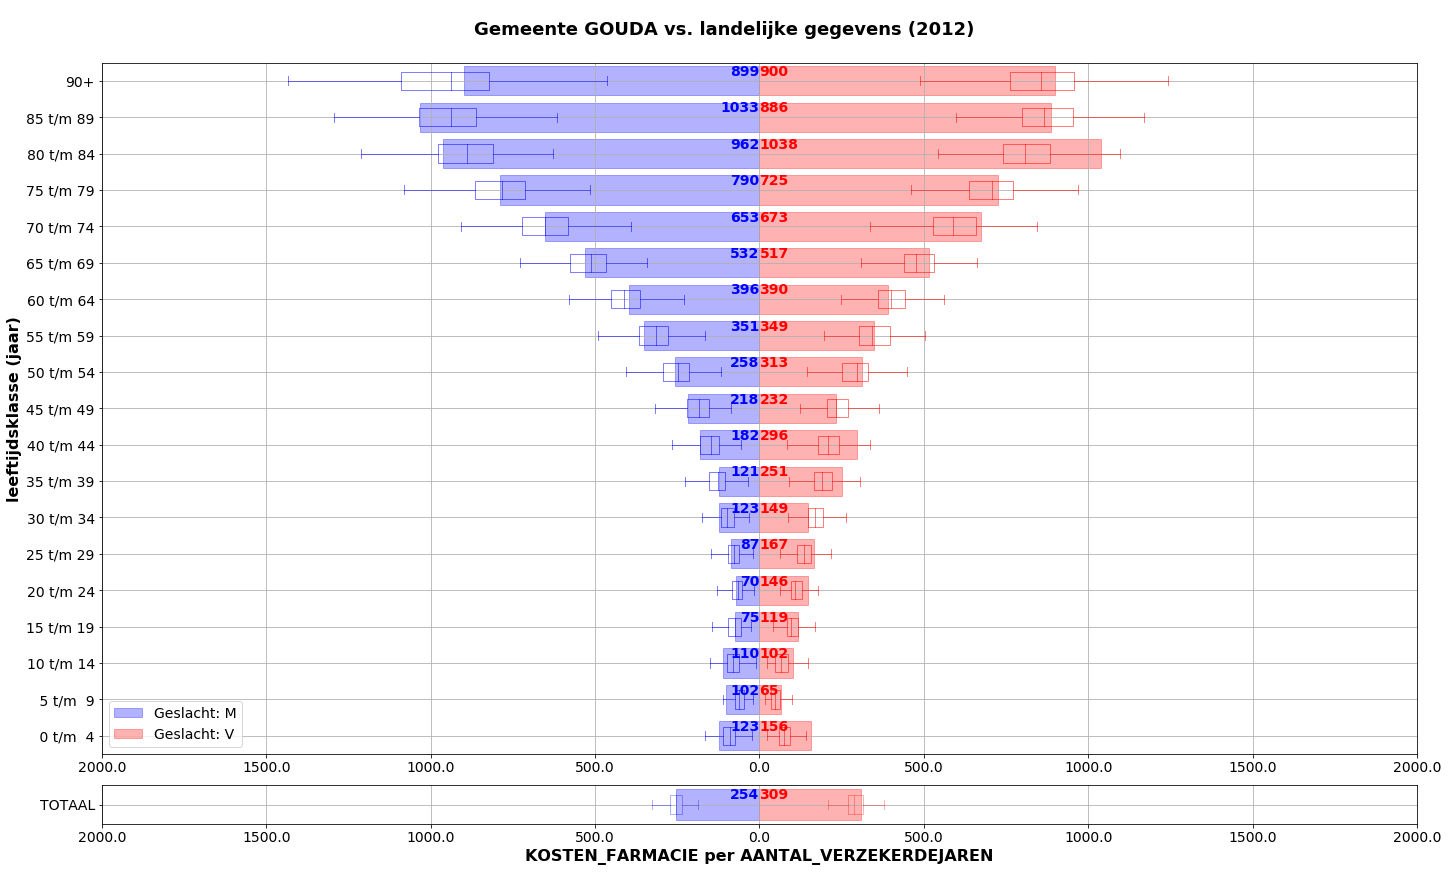

In [13]:
def plotPopulationPyramid_old(df_municipalities, df_country, df_boxplot, yearAnalysis, municipalityAnalysis, costAnalysis, perAnalysis):
    """Plot a 'population pyramid' of the country averages including corresponding error bars as well as the values from
    the selected municipality.

    Parameters:
        df_municipalities (dataframe): the dataframe containing information about the selected municipality
        df_country (dataframe): the dataframe containing the information about the country averages
        df_boxplot (dataframe): the dataframe containing the information required for showing the boxplots (prepared by the function prepareBoxplotData)
        yearAnalysis (str): used for showing the proper title and creating the proper filename for export
        municipalityAnalysis (str): used for determining which municipality will be shown in the pyramid
        costAnalysis (str): determines which costs column will be analysed. If empty ('') the perAnalysis column will be displayed
        perAnalysis (str): the selected costs column will be normalized by dividing it by the indicated 'per' column (e.g. per 'AANTAL_VERZEKERDEJAREN')
    """
    if costAnalysis != '':
        analysisColumnName = costAnalysis + ' per ' + perAnalysis
    else:
        analysisColumnName = perAnalysis
        
    # X contains the list of different age-categories
    X = np.array(df_boxplot['V'].columns.values)
    
    # Now, we finally plot
    fig = plt.figure(figsize=(20, 12), constrained_layout=True)
    plt.rcParams.update({'font.size': fontSize})
    _ = fig.suptitle('Gemeente ' + municipalityAnalysis + ' vs. landelijke gegevens (' + yearAnalysis + ')', fontweight='bold', fontsize=fontSize+4)
    gs = GridSpec(20, 1, figure = fig)

    ax1 = fig.add_subplot(gs[1:19, 0])
    
    # First, show the gender specific detailed data from the selected municipality
    men_pop   = fillAgeCategories(df_municipalities[df_municipalities['GEMEENTENAAM']==municipalityAnalysis], 'M', analysisColumnName, X)
    women_pop = fillAgeCategories(df_municipalities[df_municipalities['GEMEENTENAAM']==municipalityAnalysis], 'V', analysisColumnName, X)
    
    _ = ax1.barh(range(1, len(men_pop)   + 1), -men_pop,   color = 'b', edgecolor='b', height=0.8, alpha=0.3, label='Geslacht: M')
    _ = ax1.barh(range(1, len(women_pop) + 1),  women_pop, color = 'r', edgecolor='r', height=0.8, alpha=0.3, label='Geslacht: V')

    # Show values with the bars
    for category, value in enumerate(men_pop):
        _ = ax1.text(0, 1 + category + 0.25, str(round(value)), color='b', va='center', ha='right', fontweight='bold')
    for category, value in enumerate(women_pop):
        _ = ax1.text(0, 1 + category + 0.25, str(round(value)), color='r', va='center', ha='left', fontweight='bold')

    # And the corresponding boxplots for the country-wide data    
    draw_boxplot(ax1, -df_boxplot['M'], 'b', 'b', alpha=0.5, showfliers=False)
    draw_boxplot(ax1,  df_boxplot['V'], 'r', 'r', alpha=0.5, showfliers=False)
    
    # Add all parts of a plot which make a plot a plot
    if costAnalysis == 'KOSTEN_FARMACIE':
        _ = ax1.set_xlim(-2000, 2000) #makes it easier to compare plots from different municipalities
    _ = ax1.set_ylim(0.5, 19.5)
    xlocs, xlabs = ax1.get_xticks(), ax1.get_xticklabels()
    _ = ax1.set_xticks(xlocs)
    _ = ax1.set_xticklabels(np.absolute(xlocs))
    _ = ax1.set_yticks(range(1, 20))
    # ToDo? convert X to labels
    _ = ax1.set_yticklabels([' 0 t/m  4', ' 5 t/m  9', '10 t/m 14', '15 t/m 19', '20 t/m 24', '25 t/m 29', '30 t/m 34', '35 t/m 39', '40 t/m 44', '45 t/m 49', '50 t/m 54', '55 t/m 59', '60 t/m 64', '65 t/m 69', '70 t/m 74', '75 t/m 79', '80 t/m 84', '85 t/m 89', '90+'])
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('leeftijdsklasse (jaar)', fontweight='bold', fontsize=fontSize+2)
    _ = ax1.grid()
    _ = ax1.legend(loc='lower left')

    ax2 = fig.add_subplot(gs[19,0])

    # Only show total data (at the bottom of the pyramid) for the 'cost' part; not the 'per' part
    # Second, show the gender specific total data from the selected municpality
    men_pop   = df_country.loc[municipalityAnalysis, analysisColumnName + ' M']
    women_pop = df_country.loc[municipalityAnalysis, analysisColumnName + ' V']

    _ = ax2.barh(1, -men_pop,   color = 'b', edgecolor='b', height=0.8, alpha=0.3)
    _ = ax2.barh(1,  women_pop, color = 'r', edgecolor='r', height=0.8, alpha=0.3)

    # Show values with the bars
    _ = ax2.text(0, 1 + 0.25, str(int(round(men_pop))),   color='b', va='center', ha='right', fontweight='bold')
    _ = ax2.text(0, 1 + 0.25, str(int(round(women_pop))), color='r', va='center', ha='left', fontweight='bold')

    # And the corresponding boxplots for the country-wide data
    draw_boxplot(ax2, -df_country[analysisColumnName + ' M'], 'b', 'b', alpha=0.3, showfliers=False)
    draw_boxplot(ax2,  df_country[analysisColumnName + ' V'], 'r', 'r', alpha=0.3, showfliers=False)

    # Add all parts of a plot which make a plot a plot
    if costAnalysis == 'KOSTEN_FARMACIE':
        _ = ax2.set_xlim(ax1.get_xlim()) #makes it easier to compare plots from different municipalities
        xlocs, xlabs = ax1.get_xticks(), ax1.get_xticklabels()
    else:
        xlocs, xlabs = ax2.get_xticks(), ax2.get_xticklabels()
    _ = ax2.set_ylim(0.5, 1.5)
    _ = ax2.set_xticks(xlocs)
    _ = ax2.set_xticklabels(np.absolute(xlocs))
    _ = ax2.set_yticklabels( ['TOTAAL'])
    _ = ax2.set_xlabel(analysisColumnName, fontweight='bold', fontsize=fontSize+2)
    _ = ax2.grid()

    plt.show()

    if export:
        fig.savefig('figs/' + municipalityAnalysis + '_' + analysisColumnName + '_' + yearAnalysis + '.png')
    
plotPopulationPyramid_old(df_municipalities, df_country_old, df_boxplotData_cost, analyse_jaar, analyse_gemeente, analyse_kosten, analyse_per)

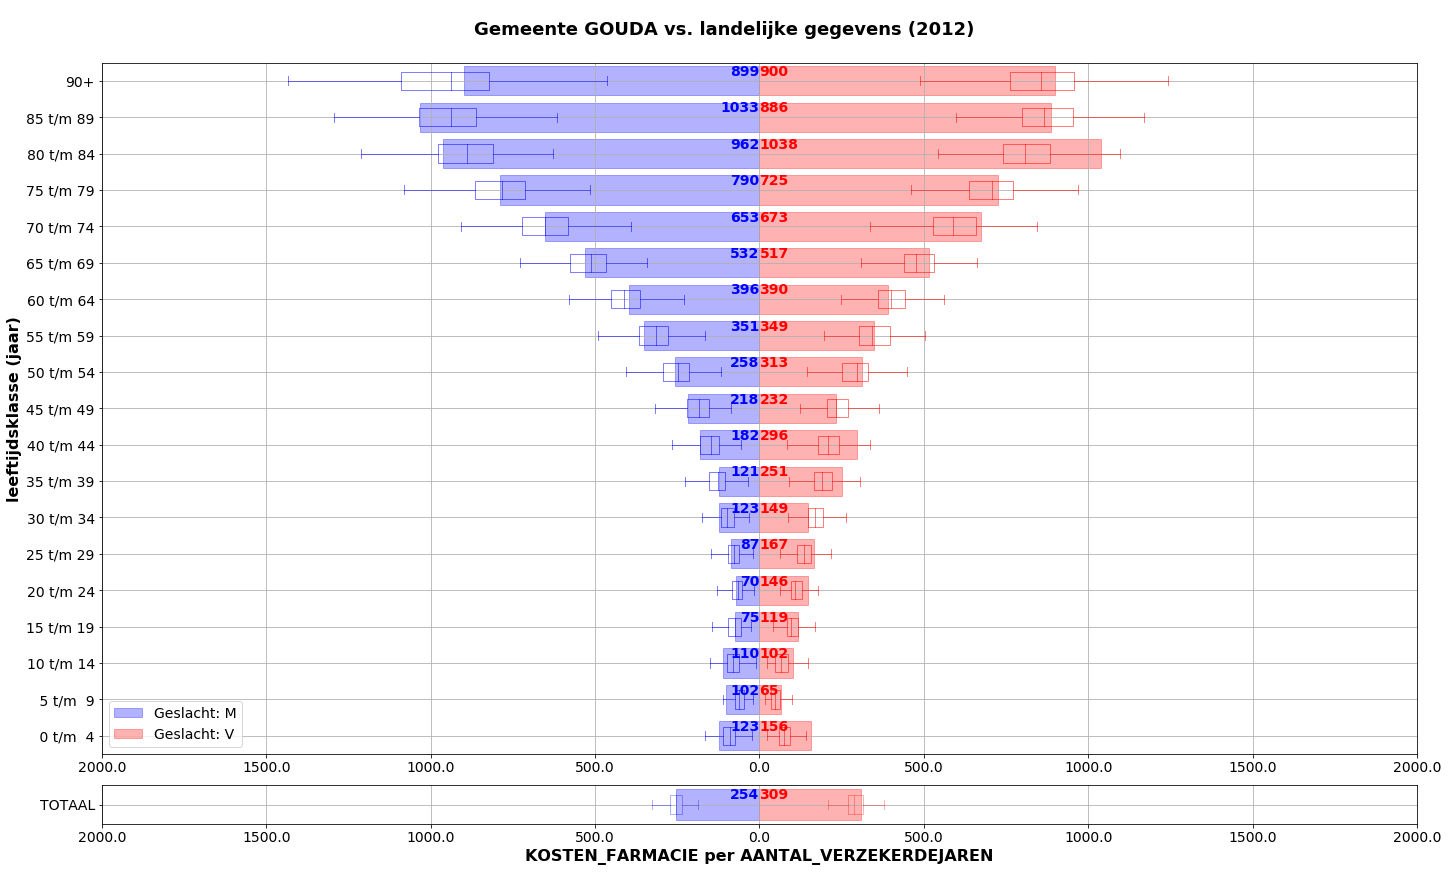

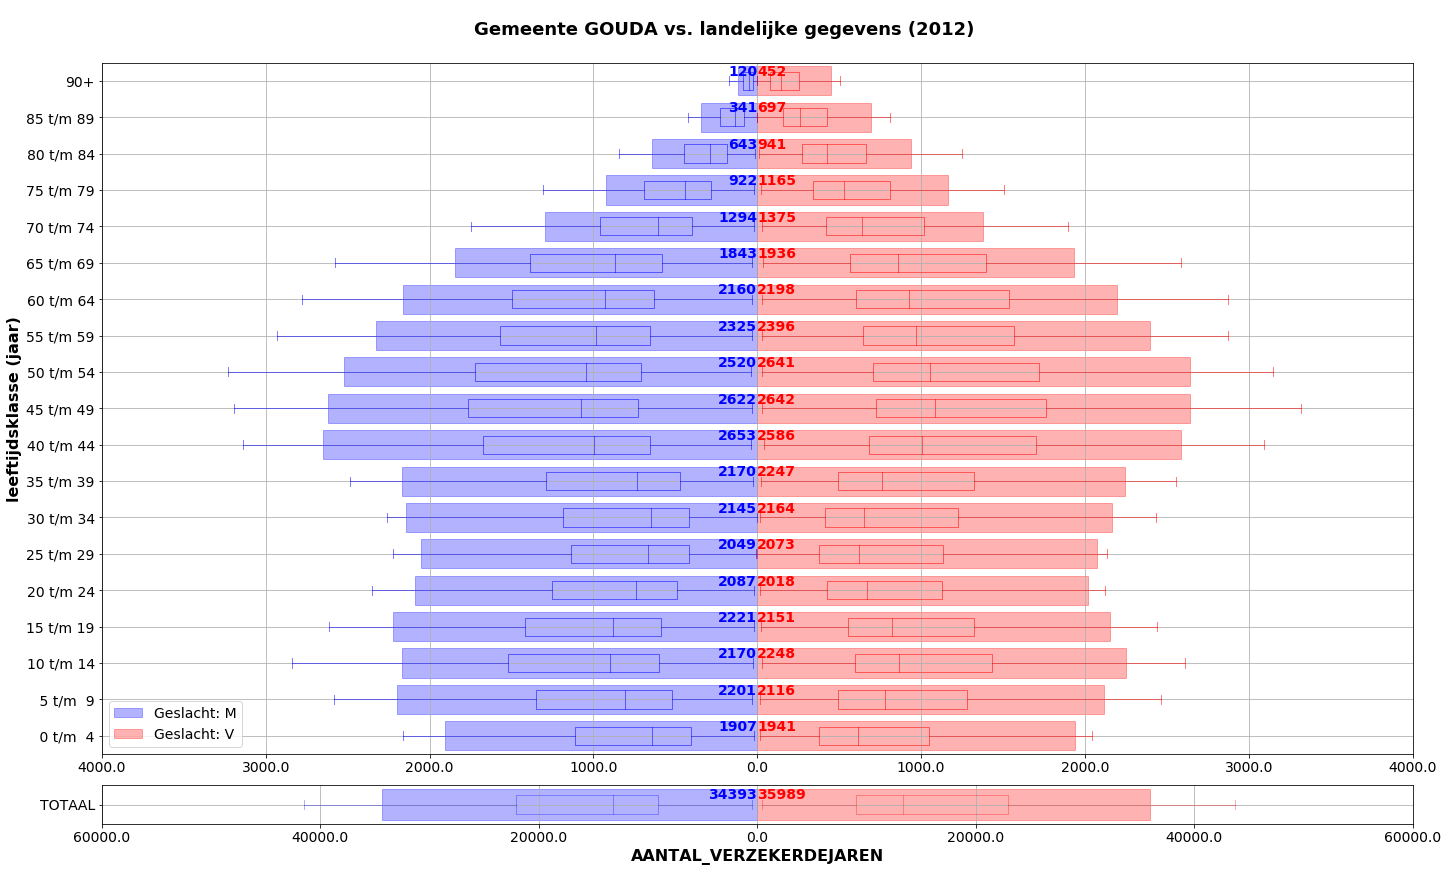

In [14]:
plotPopulationPyramid_old(df_municipalities, df_country_old, df_boxplotData_cost, analyse_jaar, analyse_gemeente, analyse_kosten, analyse_per)
plotPopulationPyramid_old(df_municipalities, df_country_old, df_boxplotData_per, analyse_jaar, analyse_gemeente, '', analyse_per)

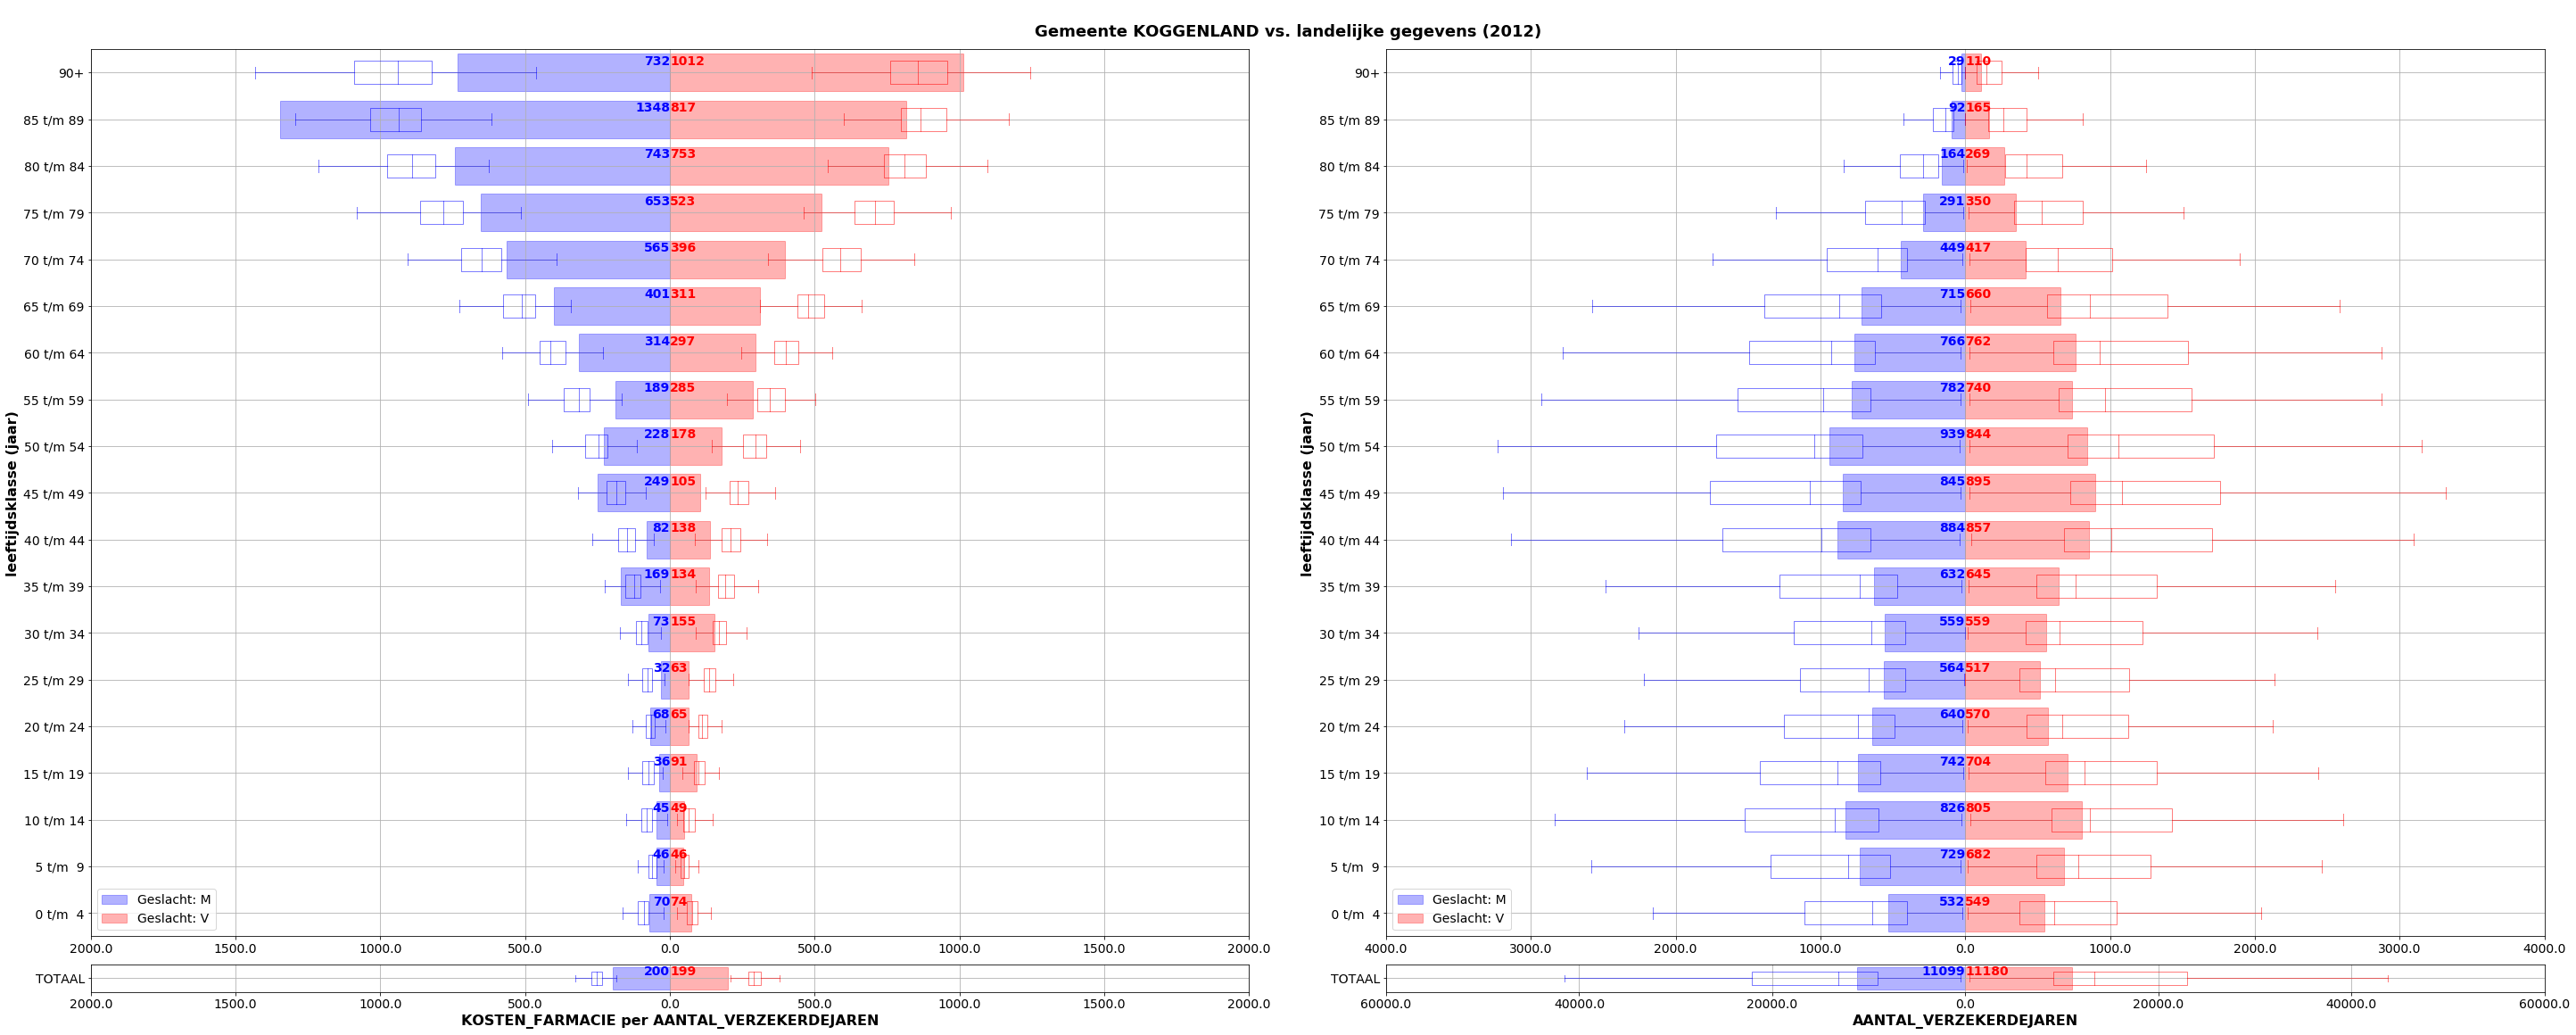

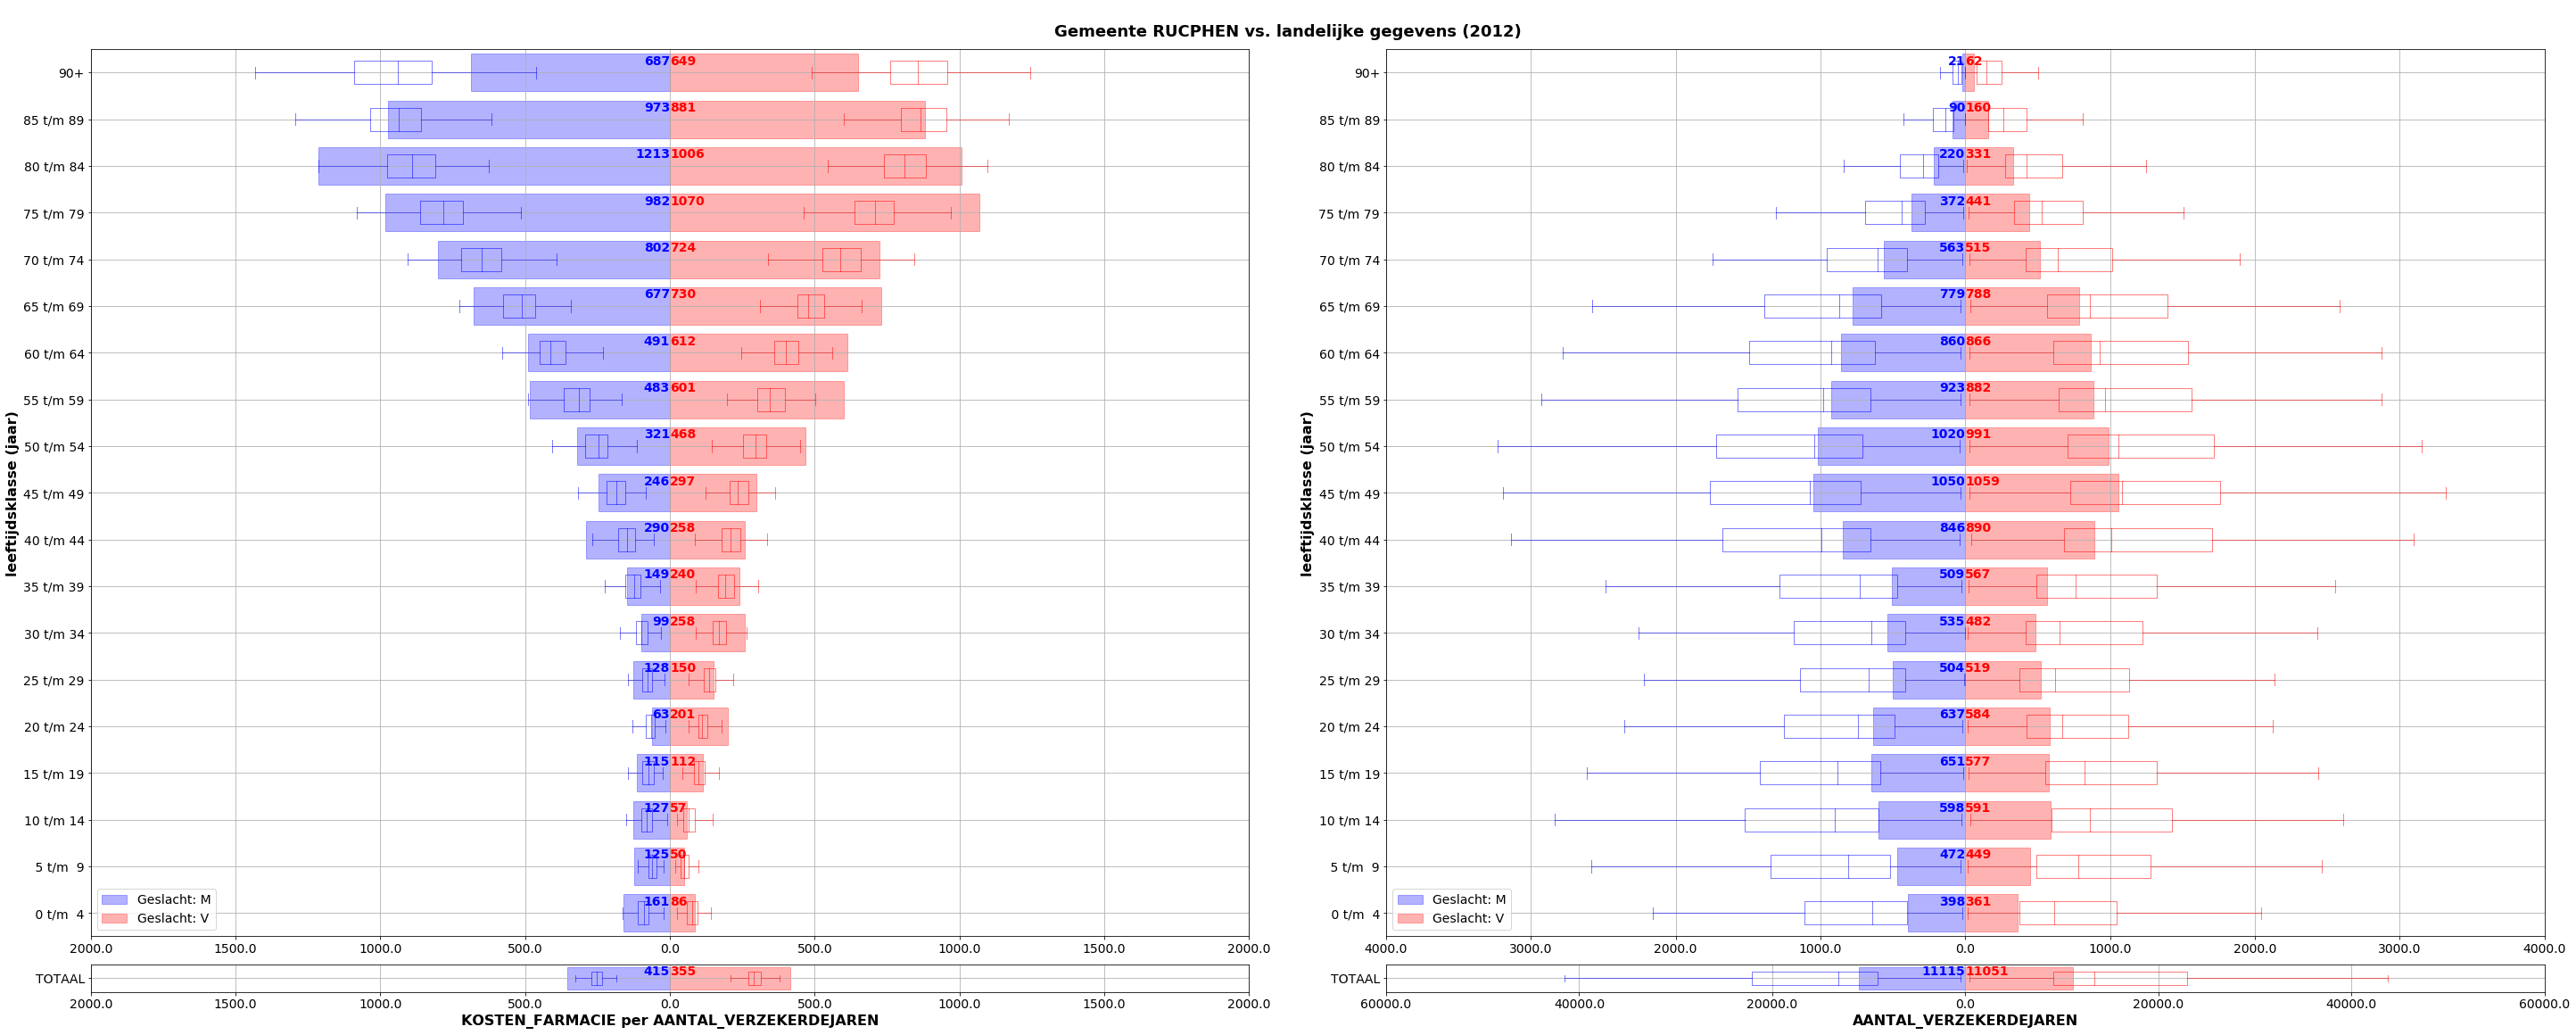

In [15]:
# Will be False after the first calculations are made, removing necessity to do some things over and over again
firstPass = True

df_all                  = pd.DataFrame()
df_all_municipalities   = pd.DataFrame()
df_all_boxplot          = pd.DataFrame()
df_all_country          = pd.DataFrame()
df_all_country_gender   = pd.DataFrame()
df_all_country_outliers = pd.DataFrame()

currentYear = ''
currentCost = ''
currentPer  = ''

def allInOne (yearAnalysis, municipalityAnalysis, costAnalysis, perAnalysis):
    """Perform full analysis in one go."""
    global currentYear, currentCost, currentPer, firstPass
    global df_all_municipalities, df_all_boxplot, df_all_country, df_all_country_gender, df_all_country_outliers
    
    analysisColumnName = costAnalysis + ' per ' + perAnalysis
    
    if yearAnalysis != currentYear or costAnalysis != currentCost or perAnalysis != currentPer:
        firstPass = True
    if firstPass:
        df_all                               = importVektisDataMunicipalities(yearAnalysis, costAnalysis, perAnalysis, online, 10000)
        df_all_municipalities                = processMunicipalities(df_all, costAnalysis, perAnalysis)
        df_all_boxplot                       = prepareBoxplotData(df_all, costAnalysis, perAnalysis)
        df_all_country,df_all_country_gender = processCountry(df_all, costAnalysis, perAnalysis)
        df_all_country_outliers              = calculateOutliers(df_all_country, analyse_kosten, analyse_per)
        
        currentYear = yearAnalysis
        currentCost = costAnalysis
        currentPer  = perAnalysis
        
        firstPass = False
    
    plotPopulationPyramid(df_all_municipalities, df_all_country_gender, df_all_boxplot, yearAnalysis, municipalityAnalysis, costAnalysis, perAnalysis)
    
    if export:
        df_all_municipalities.to_csv(             'data/df_vektis_demography_' + yearAnalysis + '_' + municipalityAnalysis + '.csv', decimal=',', index=True)
        df_all_country[analysisColumnName].to_csv('data/df_vektis_'            + yearAnalysis +                              '.csv', decimal=',', index=True, header=True)
        df_all_country_outliers.to_csv(           'data/outliers_'             + yearAnalysis +                              '.csv', decimal=',', index=False)

# Let's show the two municipality with the largest deviation from the country average.
allInOne(analyse_jaar, df_country_outliers.iloc[0,0],  analyse_kosten, analyse_per)
allInOne(analyse_jaar, df_country_outliers.iloc[-1,0], analyse_kosten, analyse_per)
    
if False:
    allInOne('2011','URK','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2012','URK','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2013','URK','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2014','URK','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2015','URK','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2016','URK','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')

    allInOne('2011','PEKELA','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2012','PEKELA','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2013','PEKELA','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2014','PEKELA','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2015','PEKELA','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')
    allInOne('2016','PEKELA','KOSTEN_FARMACIE','AANTAL_VERZEKERDEJAREN')